 **- Things to improve:**
 - unnecessary lines in triangulation stage





In [ ]:
if 'google.colab' in str(get_ipython()):
  !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
import fullcontrol as fc
from math import tau, sin

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.0 MB/s eta 0:00:00


8


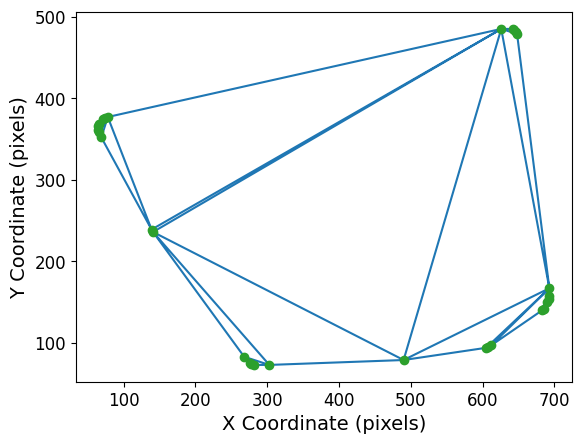

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.spatial
from scipy.spatial import Delaunay

#import fullcontrol as fc
import math
import random

# plot_controls = fc.PlotControls(raw_data=True)
# gcode_controls = fc.GcodeControls(printer_name='prusa_i3')

# steps = []
# step_count = 0
# plot_data = fc.transform(steps, 'plot', plot_controls)

img = cv2.imread('/content/failure_mask.png')


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
cv2.bitwise_not(thresh, thresh)

cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
print(len(cnts))

# Find the convex hull object for each contour
hull_list = []
for i in range(len(cnts)):
    hull = cv2.convexHull(cnts[i])
    hull_list.append(hull)

for i in range(len(cnts)):
  cv2.drawContours(img, [cnts[i]], -1, (0,255,0), 4)
  cv2.drawContours(img, hull_list, i, (0,0,255), 2)

all_in_one_contours = np.vstack(cnts)
all_in_one_hull = cv2.convexHull(all_in_one_contours)


cv2.drawContours(img, [all_in_one_hull], 0, (255,0,0), 2)

#get coordinates for triangulation ----------------------------------------------------------------------------------------------------------------------
x_coordinates = [all_in_one_hull.T[0]]
y_coordinates = [all_in_one_hull.T[1]]
x_coordinates_flat = np.array(x_coordinates).flatten()
y_coordinates_flat = np.array(y_coordinates).flatten()

# Create Delaunay triangulation
points = np.array([x_coordinates_flat, y_coordinates_flat]).T
triangulation = Delaunay(points)

plt.triplot(points[:, 0], points[:, 1], triangulation.simplices)
plt.plot(points[:, 0], points[:, 1], 'o')

plt.xlabel('X Coordinate (pixels)', fontsize=14)
plt.ylabel('Y Coordinate (pixels)', fontsize=14)

# Set consistent font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()






In [ ]:
# list for all x and y coordinates for all vertexes
all_x_coordinates = []
all_y_coordinates = []

#conversion factor
ppm = 4
pixel_to_mm = 1/ppm # 4 pixel/mm

# add values to the list
for triangle_indices in triangulation.simplices:
    triangle_coordinates = points[triangle_indices]
    x_coords = triangle_coordinates[:, 0]
    y_coords = triangle_coordinates[:, 1]

    x_coords_mm = [x * pixel_to_mm for x in x_coords]
    y_coords_mm = [y * pixel_to_mm for y in y_coords]
    all_x_coordinates.extend(x_coords_mm)
    all_y_coordinates.extend(y_coords_mm)


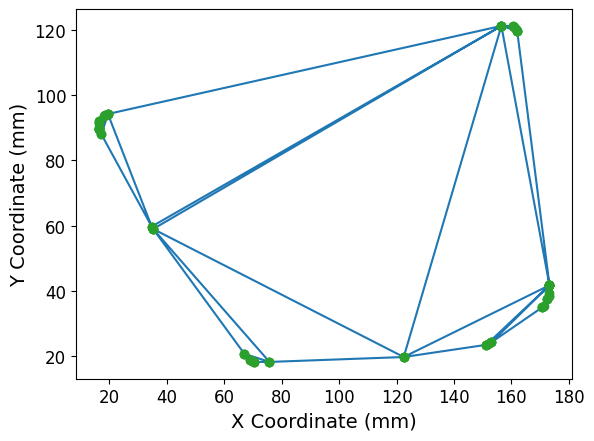

In [ ]:
# Create Delaunay triangulation
points = np.array([all_x_coordinates,all_y_coordinates]).T
triangulation = Delaunay(points)

plt.triplot(points[:, 0], points[:, 1], triangulation.simplices)
plt.plot(points[:, 0], points[:, 1], 'o')

plt.xlabel('X Coordinate (mm)', fontsize=14)
plt.ylabel('Y Coordinate (mm)', fontsize=14)

# Set consistent font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
import math


plot_controls = fc.PlotControls(raw_data=True)

initial_settings = {
    "primer": "no_primer",
}
gcode_controls = fc.GcodeControls(printer_name='prusa_i3', initialization_data=initial_settings)

steps = []
step_count = 0
plot_data = fc.transform(steps, 'plot', plot_controls)

steps.append(fc.Extruder(on=False))

#variables for each traingle
xd = 0
yd = 0
zd = 0

steps.append(fc.Extruder(on=True))
def mid(tx1,tx2,tx3,ty1,ty2,ty3,tz1,tz2,tz3):
  global xd,yd,zd
  xd = (tx1+tx2+tx3)/3
  yd = (ty1 +ty2+ty3)/3
  zd = (tz1+ tz2+tz3)/3

  steps.append(fc.Extruder(on=False))
  steps.append(fc.Point(x=xd, y=yd,z= zd))
  steps.append(fc.Extruder(on=True))
def first_count(x_1,x2n,x_2,y_1,y2n,y_2,z_1,z2n,z_2,x_mid,y_mid,z_mid):
  global tri
  #point 1
  d1x = (x_1 -x_mid)
  d1y = (y_1 -y_mid)
  d1z = (z_1 -z_mid)
   #point 2
  d2x = (x2n -x_mid)
  d2y = (y2n -y_mid)
  d2z = (z2n -z_mid)
   #point 3
  d3x = (x_2 -x_mid)
  d3y = (y_2 -y_mid)
  d3z = (z_2 -z_mid)

  #area
  a = int(math.sqrt((x_2 - x_1)** 2 + (y_2- y_1) ** 2 + (z_2 - z_1)**2))
  if a <= 0:
    a = int(math.sqrt((x_1 - x_2)** 2 + (y_1- y_2) ** 2 + (z_1 - z_2)**2))

  b = int(math.sqrt((x2n - x_2)** 2 + (y2n- y_2) ** 2 + (z2n - z_2)**2))
  if b <= 0:
    b = int(math.sqrt((x_2 - x2n)** 2 + (y_2- y2n) ** 2 + (z_2 - z2n)**2))

  c = int(math.sqrt((x2n - x_1)** 2 + (y2n- y_1) ** 2 + (z2n - z_1)**2))
  if c <= 0:
    c = int(math.sqrt((x_1 - x2n)** 2 + (y_1- y2n) ** 2 + (z_1 - z2n)**2))

  s = (a+b+c)/2

  Ar = math.sqrt(s*(abs(s-a))*(abs(s-b))*(abs(s-c)))

  #invalid triangle
  if (s-a) <=0 or (s-b) <=0 or (s-c)<=0:
    Ar =0

  inc = 0
  if 300 <= Ar and Ar <= 500:
    inc = 0.3

  elif Ar >= 500 and Ar < 2000:
    inc = 0.1

  elif Ar >= 2000:
    inc = 0.05


  #first mid-triangle point
  p1x = (d1x * 0.15) + x_mid
  p1y = (d1y * 0.15) + y_mid
  p1z = (d1z * 0.15) + z_mid

  p2x = (d2x * 0.15) + x_mid
  p2y = (d2y * 0.15) + y_mid
  p2z = (d2z * 0.15) + z_mid

  p3x = (d3x * 0.15) + x_mid
  p3y = (d3y * 0.15) + y_mid
  p3z = (d3z * 0.15) + z_mid

  steps.append(fc.Point(x=p1x, y=p1y,z= p1z))
  steps.append(fc.Point(x=p2x, y=p2y,z= p2z))
  steps.append(fc.Point(x=p3x, y=p3y,z= p3z))

  if inc == 0.1:
    for bob in range (9):
      p1x = (d1x * (0.15 + (bob* inc))) + x_mid
      p1y = (d1y * (0.15 + (bob* inc))) + y_mid
      p1z = (d1z * (0.15 + (bob* inc))) + z_mid

      p2x = (d2x * (0.15 + (bob* inc))) + x_mid
      p2y = (d2y * (0.15 + (bob* inc))) + y_mid
      p2z = (d2z * (0.15 + (bob* inc))) + z_mid

      p3x = (d3x * (0.15 + (bob* inc))) + x_mid
      p3y = (d3y * (0.15 + (bob* inc))) + y_mid
      p3z = (d3z * (0.15 + (bob* inc))) + z_mid

      steps.append(fc.Point(x=(d1x * (0.15 + (bob* inc))) + x_mid, y=(d1y * (0.15 + (bob* inc))) + y_mid,z= (d1z * (0.15 + (bob* inc))) + z_mid))
      steps.append(fc.Point(x=(d2x * (0.15 + (bob* inc))) + x_mid, y=(d2y * (0.15 + (bob* inc))) + y_mid,z= (d2z * (0.15 + (bob* inc))) + z_mid))
      steps.append(fc.Point(x=(d3x * (0.15 + (bob* inc))) + x_mid, y=(d3y * (0.15 + (bob* inc))) + y_mid,z= (d3z * (0.15 + (bob* inc))) + z_mid))
  if inc == 0.3:
    for bob in range (3):
      p1x = (d1x * (0.15 + (bob* inc))) + x_mid
      p1y = (d1y * (0.15 + (bob* inc))) + y_mid
      p1z = (d1z * (0.15 + (bob* inc))) + z_mid

      p2x = (d2x * (0.15 + (bob* inc))) + x_mid
      p2y = (d2y * (0.15 + (bob* inc))) + y_mid
      p2z = (d2z * (0.15 + (bob* inc))) + z_mid

      p3x = (d3x * (0.15 + (bob* inc))) + x_mid
      p3y = (d3y * (0.15 + (bob* inc))) + y_mid
      p3z = (d3z * (0.15 + (bob* inc))) + z_mid

      steps.append(fc.Point(x=(d1x * (0.15 + (bob* inc))) + x_mid, y=(d1y * (0.15 + (bob* inc))) + y_mid,z= (d1z * (0.15 + (bob* inc))) + z_mid))
      steps.append(fc.Point(x=(d2x * (0.15 + (bob* inc))) + x_mid, y=(d2y * (0.15 + (bob* inc))) + y_mid,z= (d2z * (0.15 + (bob* inc))) + z_mid))
      steps.append(fc.Point(x=(d3x * (0.15 + (bob* inc))) + x_mid, y=(d3y * (0.15 + (bob* inc))) + y_mid,z= (d3z * (0.15 + (bob* inc))) + z_mid))
  if inc == 0.05:
    for bob in range (17):
      p1x = (d1x * (0.15 + (bob* inc))) + x_mid
      p1y = (d1y * (0.15 + (bob* inc))) + y_mid
      p1z = (d1z * (0.15 + (bob* inc))) + z_mid

      p2x = (d2x * (0.15 + (bob* inc))) + x_mid
      p2y = (d2y * (0.15 + (bob* inc))) + y_mid
      p2z = (d2z * (0.15 + (bob* inc))) + z_mid

      p3x = (d3x * (0.15 + (bob* inc))) + x_mid
      p3y = (d3y * (0.15 + (bob* inc))) + y_mid
      p3z = (d3z * (0.15 + (bob* inc))) + z_mid

      steps.append(fc.Point(x=(d1x * (0.15 + (bob* inc))) + x_mid, y=(d1y * (0.15 + (bob* inc))) + y_mid,z= (d1z * (0.15 + (bob* inc))) + z_mid))
      steps.append(fc.Point(x=(d2x * (0.15 + (bob* inc))) + x_mid, y=(d2y * (0.15 + (bob* inc))) + y_mid,z= (d2z * (0.15 + (bob* inc))) + z_mid))
      steps.append(fc.Point(x=(d3x * (0.15 + (bob* inc))) + x_mid, y=(d3y * (0.15 + (bob* inc))) + y_mid,z= (d3z * (0.15 + (bob* inc))) + z_mid))

def fill():
  global tri
  #first plot in fullcontrol ----------------------------------------------------------------------------------------------------

  number_for_triangle = 0
  for i, triangle in enumerate(triangulation.simplices):
      for vertex_index in triangle:
          number_for_triangle += 1
          steps.append(fc.Point(x=float({points[vertex_index, 0]}.pop()), y=float({points[vertex_index, 1]}.pop()), z=0))
          steps.append(fc.Extruder(on=True))  # Always turn the extruder on for each vertex

          # Check if this is the third vertex of the triangle
          if number_for_triangle % 3 == 0:
              steps.append(fc.Extruder(on=False))  # Turn the extruder off after every third vertex

      # Reset the count for the next triangle
      number_for_triangle = 0


  #fill in triangles
  for tri in range (int(len(all_x_coordinates))):
    if tri % 3 == 0:
      mid(all_x_coordinates[tri],  all_x_coordinates[tri+1], all_x_coordinates[tri+2], all_y_coordinates[tri], all_y_coordinates[tri+1], all_y_coordinates[tri+2], 0,0, 0)
      first_count(all_x_coordinates[tri],  all_x_coordinates[tri+1], all_x_coordinates[tri+2], all_y_coordinates[tri], all_y_coordinates[tri+1], all_y_coordinates[tri+2], 0,0,0, xd,yd,zd)
  pr()
def pr():
  plot_data = fc.transform (steps, 'plot')
  print(fc.transform(steps, 'gcode', gcode_controls))
  #remove above comment for custom gcode

fill()



; Time to print!!!!!
; GCode created with FullControl - tell us what you're printing!
; info@fullcontrol.xyz or tag FullControlXYZ on Twitter/Instagram/LinkedIn/Reddit/TikTok 

M140 S40 ; set bed temp and continue
M104 S210 ; set hotend temp and continue
M190 S40 ; set bed temp and wait
M109 S210  ; set hotend temp and wait
G28 ; home axes ; ; including mesh bed level
G90 ; absolute coordinates
G21 ; set units to millimeters
M83 ; relative extrusion
M106 S255 ; set fan speed
M220 S100 ; set speed factor override percentage
M221 S100 ; set extrude factor override percentage
G0 F8000 X5.0 Y5.0 Z10.0
G1 F250 E20.7876
G0 F250 Z50.0
G0 F8000 X10.0 Y10.0 Z0.3
;-----
; END OF STARTING PROCEDURE
;-----

G1 F1000 X162.0 Y119.75 Z0.0 E6.235646
G1 F1000 X156.5 Y121.25 E0.189612
G1 F1000 X173.25 Y41.75 E2.702232
G0 F8000 X156.5 Y121.25
G1 F1000 X122.5 Y19.75 E3.560272
G1 F1000 X173.25 Y41.75 E1.839728
G0 F8000 X162.0 Y119.75
G1 F1000 X160.5 Y121.25 E0.070555
G1 F1000 X156.5 E0.133041
G0 F8000 X35.